# Knowledge-Graph Graph Neural Network for Data Cleansing

Graph Neural Networks can help eliminate unnecessary or irrelevant information from knowledge-graphs.

In this example, we will use Langchain's LLMGraphTransformer to create a knowledge graph out of sample text about 2023, then train a graph neural network to form clusters to find data is irrelevant.

# Setup Environment



In [1]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

     \ 109.6 kB 1.2 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 743.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 31.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import time

In [4]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


### Initialize Astra DB / Cassandra

In [5]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(135877643716976) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:da337f5a-b9d1-4c81-b30e-fdbfcbe049ac> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


### Create Graph Store

In [6]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

#Build Knowledge Graph

In [7]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [8]:
text = """
Detailed Summary of 2023
Global Events and Politics:

2023 was a year of profound global political upheavals and events that reshaped the world order. The Russia-Ukraine conflict, which began in 2022, escalated with intense battles in Eastern Ukraine and widespread international sanctions against Russia. The conflict's impact extended beyond the region, causing global energy shortages and inflationary pressures. NATO expanded its presence in Eastern Europe, and several countries increased defense spending in response to the heightened threat perception.

The Middle East experienced significant turmoil, with ongoing civil wars in Syria and Yemen continuing to cause humanitarian crises. Iran's nuclear program negotiations reached a critical juncture, with renewed diplomatic efforts to prevent further proliferation. In Africa, coups and political instability were witnessed in countries like Sudan and Burkina Faso, highlighting the continent's ongoing struggles with governance and security.

Climate change remained a paramount global issue, with 2023 seeing some of the most extreme weather events on record. Devastating floods in South Asia, unprecedented wildfires in Australia and California, and severe heatwaves in Europe underscored the urgent need for comprehensive climate action. The COP28 summit, held in Dubai, saw countries commit to more ambitious targets, though debates over financing for climate adaptation and mitigation persisted.

Technology and Innovation:

Technological innovation surged forward in 2023, particularly in the realm of artificial intelligence (AI). The development of generative AI models like GPT-4 and its successors revolutionized industries from customer service to creative arts. These models exhibited remarkable capabilities in natural language understanding, image generation, and complex problem-solving. AI ethics and regulation became hotly debated topics, with governments and tech companies striving to balance innovation with responsible use.

The tech industry faced economic challenges, with several major companies, including Meta, Amazon, and Google, announcing significant layoffs and restructuring efforts. This was partly due to overexpansion during the pandemic and the need to refocus on profitability and sustainable growth. The semiconductor shortage that began in 2020 continued to affect industries, though increased investment in chip manufacturing provided some relief.

Quantum computing made notable strides, with both public and private sectors investing heavily in research and development. Companies like IBM, Google, and emerging startups demonstrated advancements in quantum processors, bringing us closer to practical quantum computing applications in cryptography, drug discovery, and complex simulations.

Science and Health:

The global health community continued to grapple with the effects of COVID-19. While vaccination rates improved and new antiviral treatments were developed, the emergence of new variants necessitated ongoing vigilance. Long COVID research gained prominence, aiming to understand and mitigate the chronic impacts of the virus on millions of people.

In space exploration, 2023 was a landmark year. NASA's Artemis program made significant progress, with Artemis II successfully orbiting the Moon and laying the groundwork for future manned missions. The James Webb Space Telescope provided unprecedented images and data on distant galaxies, exoplanets, and cosmic phenomena, advancing our understanding of the universe.

Biotechnology and genetic research yielded groundbreaking discoveries. CRISPR technology continued to evolve, enabling more precise genetic modifications and promising treatments for genetic disorders. Personalized medicine, tailored to individuals' genetic profiles, saw increased adoption, particularly in oncology and rare diseases.

Culture and Society:

The cultural landscape of 2023 was vibrant and diverse, reflecting both continuity and change. The entertainment industry rebounded strongly as in-person events, concerts, and film festivals returned to pre-pandemic levels. Streaming services maintained their dominance, producing original content that garnered critical acclaim and massive viewership. The intersection of AI and creativity was particularly noteworthy, with AI-generated music, art, and literature gaining popularity and sparking debates about the future of human creativity.

Social justice movements continued to shape public discourse. The fight for racial equality saw renewed momentum with high-profile protests and legislative efforts in the United States and globally. Gender equality and LGBTQ+ rights also advanced, with several countries enacting progressive policies and legal protections. Environmental activism, especially among younger generations, intensified. Activists pushed for more aggressive climate policies and sustainable practices, emphasizing the urgency of addressing environmental degradation.

Economics and Business:

Global economic conditions in 2023 were marked by volatility and adaptation. Inflationary pressures, driven by energy prices and supply chain disruptions, posed significant challenges for policymakers. Central banks, including the Federal Reserve and the European Central Bank, raised interest rates to combat inflation, leading to mixed economic outcomes.

The cryptocurrency market experienced dramatic fluctuations. Bitcoin and other cryptocurrencies saw periods of rapid appreciation followed by sharp declines, driven by regulatory news, technological advancements, and macroeconomic factors. Regulatory scrutiny increased globally, with governments seeking to establish clearer frameworks to govern digital assets and ensure financial stability.

The labor market underwent substantial changes as remote and hybrid work models became entrenched. This shift affected urban planning, transportation, and commercial real estate, with many companies downsizing office space and investing in digital infrastructure. The "Great Resignation" trend persisted, with workers seeking better work-life balance, higher wages, and more fulfilling careers.

Overall, 2023 was a year marked by significant challenges and remarkable advancements across various domains. It reflected the complexity and dynamism of the modern world, highlighting humanity's resilience and capacity for innovation in the face of adversity.
"""

In [9]:
from langchain_core.documents import Document
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='2023', type='Year'), Node(id='Russia-Ukraine Conflict', type='Event'), Node(id='Russia', type='Country'), Node(id='Ukraine', type='Country'), Node(id='Nato', type='Organization'), Node(id='Eastern Europe', type='Region'), Node(id='Middle East', type='Region'), Node(id='Syria', type='Country'), Node(id='Yemen', type='Country'), Node(id='Iran', type='Country'), Node(id='Africa', type='Continent'), Node(id='Sudan', type='Country'), Node(id='Burkina Faso', type='Country'), Node(id='Climate Change', type='Issue'), Node(id='Cop28 Summit', type='Event'), Node(id='Dubai', type='City'), Node(id='Artificial Intelligence', type='Technology'), Node(id='Gpt-4', type='Ai model'), Node(id='Meta', type='Company'), Node(id='Amazon', type='Company'), Node(id='Google', type='Company'), Node(id='Quantum Computing', type='Technology'), Node(id='Ibm', type='Company'), Node(id='Covid-19', type='Disease'), Node(id="Nasa'S Artemis Program", type='Program'), Node(id='Artemis Ii', type='Mission')

In [10]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

In [11]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

# Test Knowledge Graph Query

In [12]:
chain.invoke("What happened in 2023?")

AIMessage(content="In 2023, several key events took place across a range of sectors. The European Central Bank, Meta, Federal Reserve, and NASA's Artemis Program were all involved in activities during this year. Quantum Computing and AI made significant advancements, with the development of GPT-4 and advancements in CRISPR technology also noted. The entertainment industry rebounded, while remote and hybrid work models became more entrenched.\n\nIn the political world, the Middle East experienced turmoil, with civil wars in Syria and Yemen. There were also political instabilities in Africa, particularly in Sudan and Burkina Faso. The Russia-Ukraine conflict was a major event, and there were nuclear program negotiations in Iran.\n\nIn the corporate world, Google, Amazon, and Meta all underwent restructurings and announced layoffs. The Great Resignation persisted through 2023.\n\nClimate change was addressed at the COP28 Summit in Dubai, and environmental activism intensified. Social just

#Visualize Graph

In [13]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: 2023, Type: Year
ID: Russia-Ukraine Conflict, Type: Event
ID: Russia, Type: Country
ID: Ukraine, Type: Country
ID: Nato, Type: Organization
ID: Eastern Europe, Type: Region
ID: Middle East, Type: Region
ID: Syria, Type: Country
ID: Yemen, Type: Country
ID: Iran, Type: Country
ID: Africa, Type: Continent
ID: Sudan, Type: Country
ID: Burkina Faso, Type: Country
ID: Climate Change, Type: Issue
ID: Cop28 Summit, Type: Event
ID: Dubai, Type: City
ID: Artificial Intelligence, Type: Technology
ID: Gpt-4, Type: Ai model
ID: Meta, Type: Company
ID: Amazon, Type: Company
ID: Google, Type: Company
ID: Quantum Computing, Type: Technology
ID: Ibm, Type: Company
ID: Covid-19, Type: Disease
ID: Nasa'S Artemis Program, Type: Program
ID: Artemis Ii, Type: Mission
ID: James Webb Space Telescope, Type: Telescope
ID: Crispr Technology, Type: Technology
ID: Personalized Medicine, Type: Medical approach
ID: Entertainment Industry, Type: Industry
ID: Ai-Generated Music, Art, And Literature, Type: 

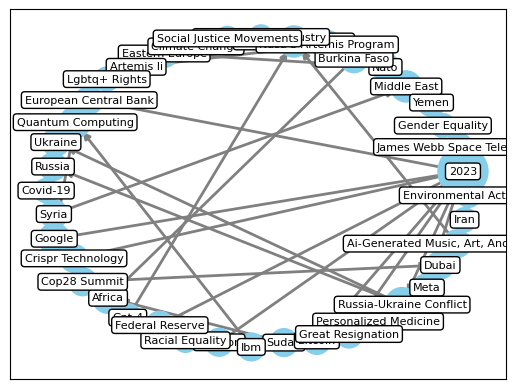

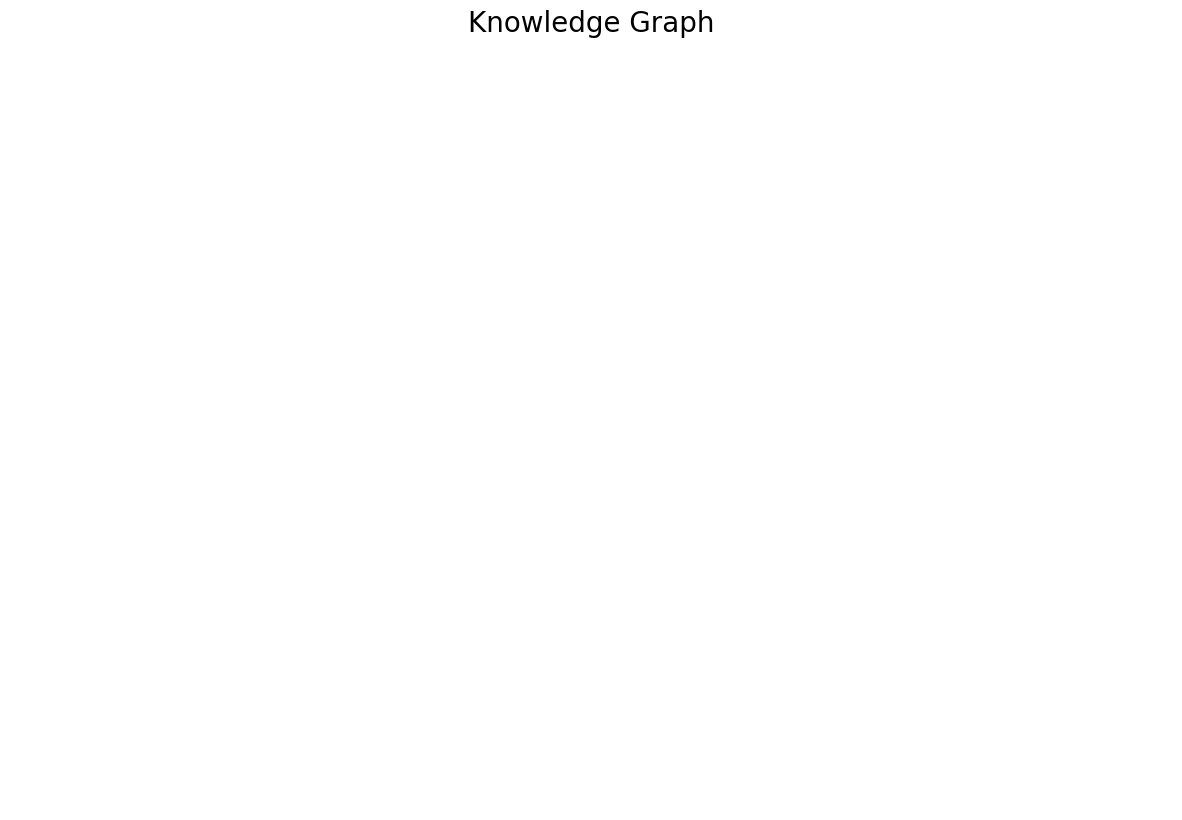

In [14]:
def visualize_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    # Identify all nodes that are sources of relationships
    source_nodes = set(relationship.source.id for doc in graph_documents for relationship in doc.relationships)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=20, iterations=200, center=(0.5, 0.5))  # Increase k value for more spacing

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [300 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Edge labels with increased font size
    #edge_labels = nx.get_edge_attributes(G, 'label')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, font_color='black')

    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.title("Knowledge Graph", fontsize=20)
    plt.axis('off')  # Hide axis
    plt.show()
visualize_graph(graph_documents)

# Transport Knowledge Graph to Pytorch Geometric Graph

In [15]:
# Custom Data class to include num_classes and num_features
from torch_geometric.data import Data
class CustomData(Data):
    def __init__(self, num_classes=None, num_features=None, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features

    @classmethod
    def from_data(cls, data, num_classes=None, num_features=None):
        obj = cls(num_classes=num_classes, num_features=num_features, **data.to_dict())
        return obj

In [16]:
from community import community_louvain
def convert_to_pyg_data(graph_documents, num_features, num_classes):
    nodes = []
    edges = []

    # Extract nodes and edges from the graph documents
    node_id_map = {}
    for doc in graph_documents:
        for idx, node in enumerate(doc.nodes):
            if node.id not in node_id_map:
                node_id_map[node.id] = len(node_id_map)
                nodes.append(node.id)
        for relationship in doc.relationships:
            source_id = node_id_map[relationship.source.id]
            target_id = node_id_map[relationship.target.id]
            edges.append((source_id, target_id))

    # Convert nodes and edges to PyTorch tensors
    num_nodes = len(node_id_map)
    x = torch.eye(num_nodes, num_features)  # Identity matrix as dummy node features
    y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)  # Random labels for demonstration

    return CustomData(x=x, edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(), y=y,
                      num_classes=num_classes, num_features=num_features)

def get_graph_stats(graph_documents):
    G = nx.Graph()

    # Extract nodes and edges from the graph documents to create a networkx graph
    for doc in graph_documents:
        for node in doc.nodes:
            G.add_node(node.id)
        for relationship in doc.relationships:
            G.add_edge(relationship.source.id, relationship.target.id)

    num_features = G.number_of_nodes()

    # Use community detection to find the number of clusters
    partition = community_louvain.best_partition(G)
    num_classes = len(set(partition.values()))

    return num_classes, num_features

### Display Graph

Number of classes: 19
Number of features: 40


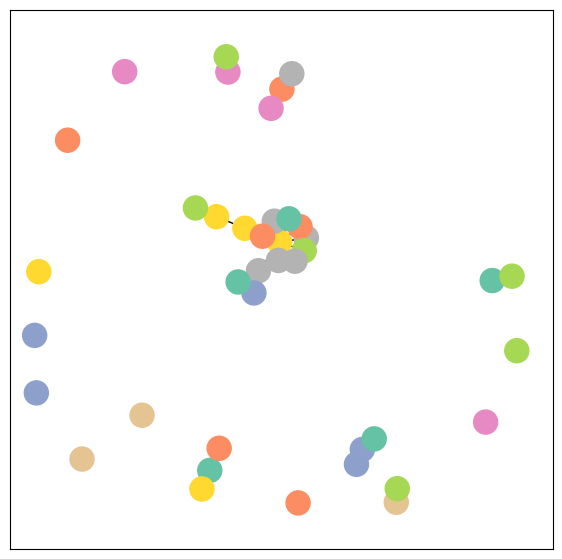

In [17]:
from torch_geometric.utils import to_networkx
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
num_classes, num_features = get_graph_stats(graph_documents)
print(f'Number of classes: {num_classes}')
print(f'Number of features: {num_features}')
data = convert_to_pyg_data(graph_documents,num_features,num_classes)
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Setup Graph Neural Network

In [18]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


Embedding shape: [40, 2]


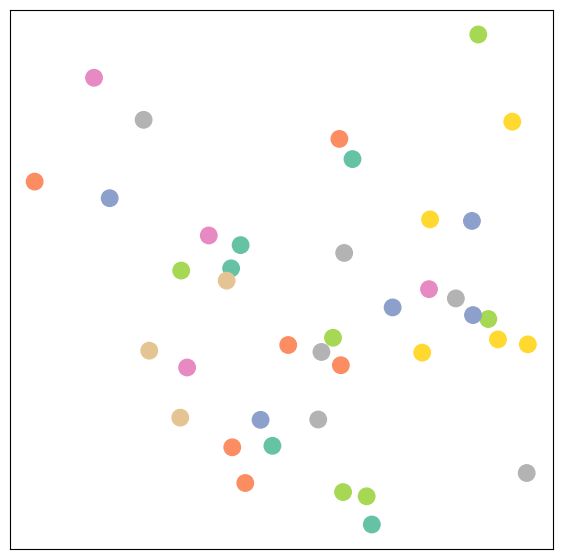

In [19]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [20]:
from IPython.display import Javascript  # Restrict height of output cell.

# Setup
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss based on all nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

<IPython.core.display.Javascript object>

# Train Graph Neural Network

Epoch: 0, Loss: 3.0006


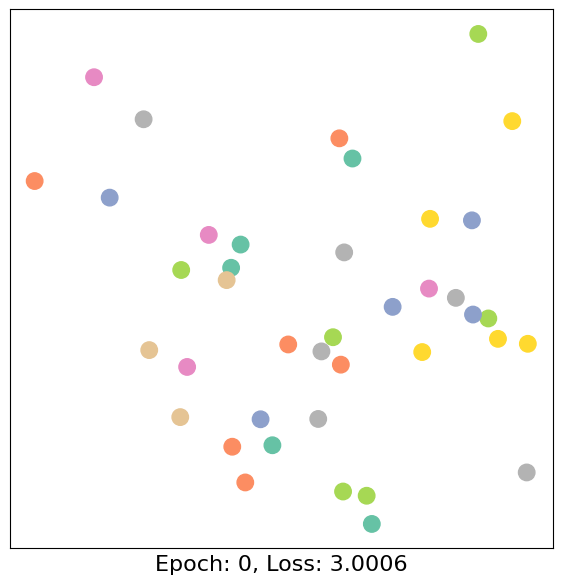

Epoch: 10, Loss: 2.8059


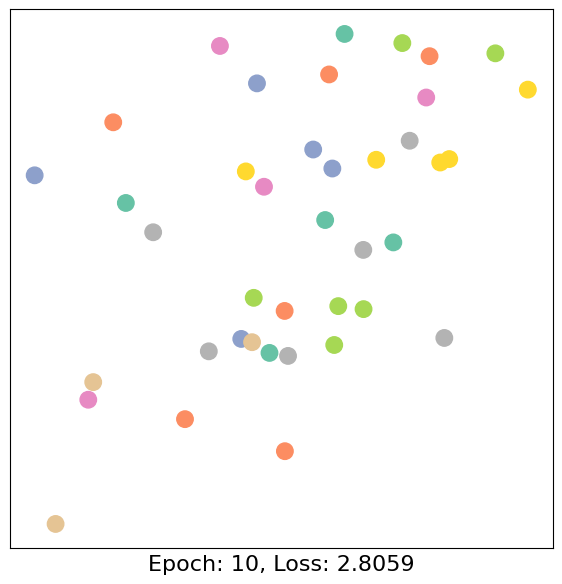

Epoch: 20, Loss: 2.6558


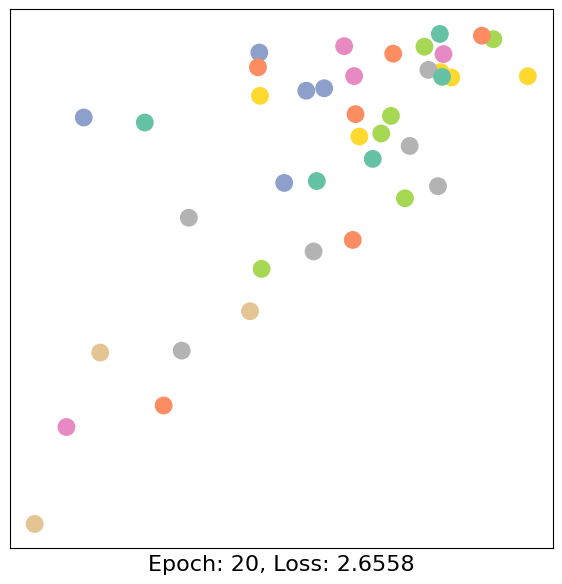

Epoch: 30, Loss: 2.4667


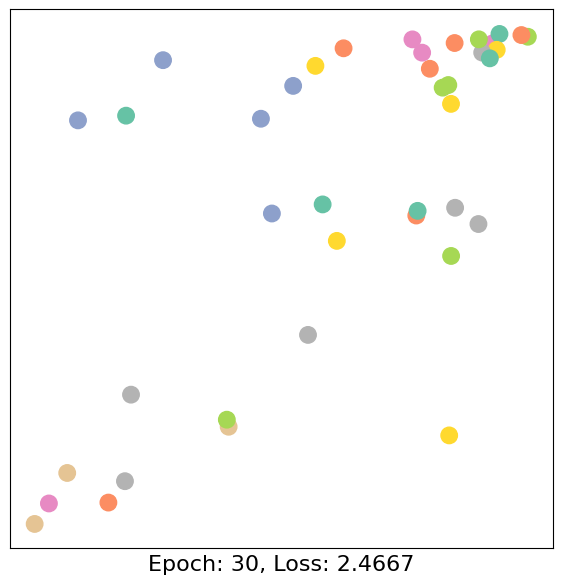

Epoch: 40, Loss: 2.2870


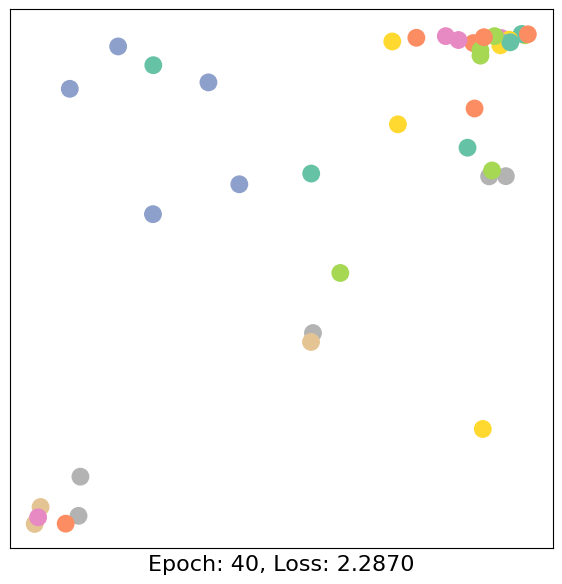

Epoch: 50, Loss: 2.1445


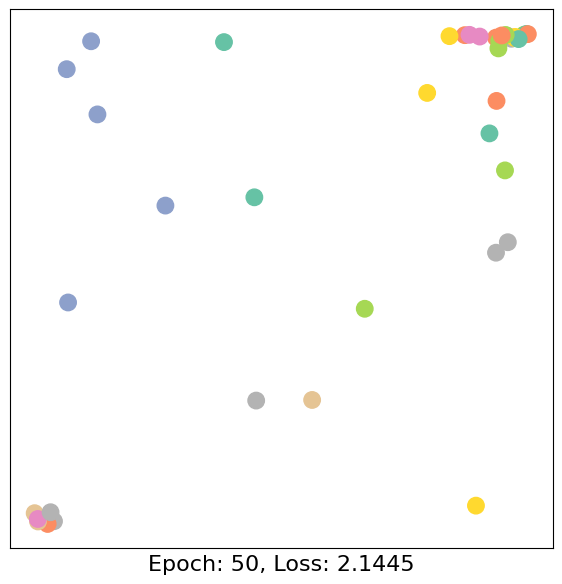

Epoch: 60, Loss: 2.0399


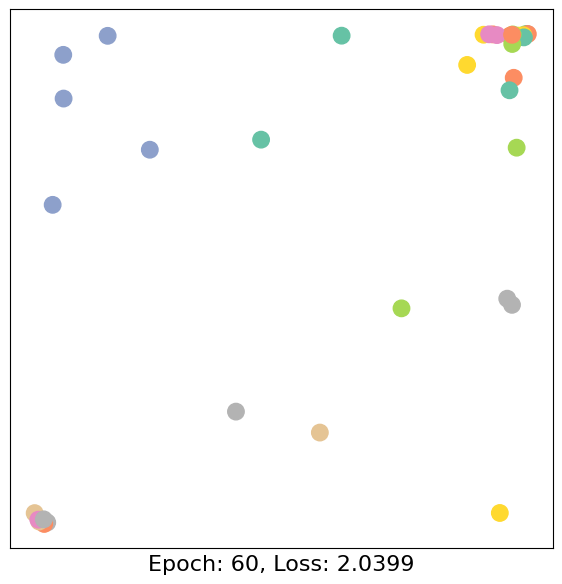

Epoch: 70, Loss: 1.9604


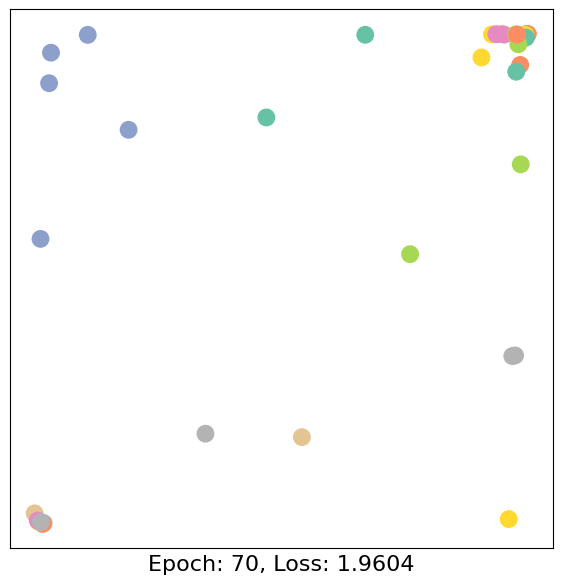

Epoch: 80, Loss: 1.8975


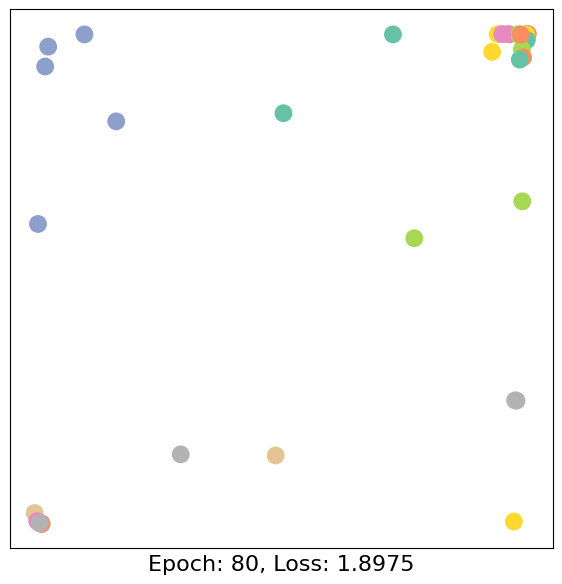

Epoch: 90, Loss: 1.8445


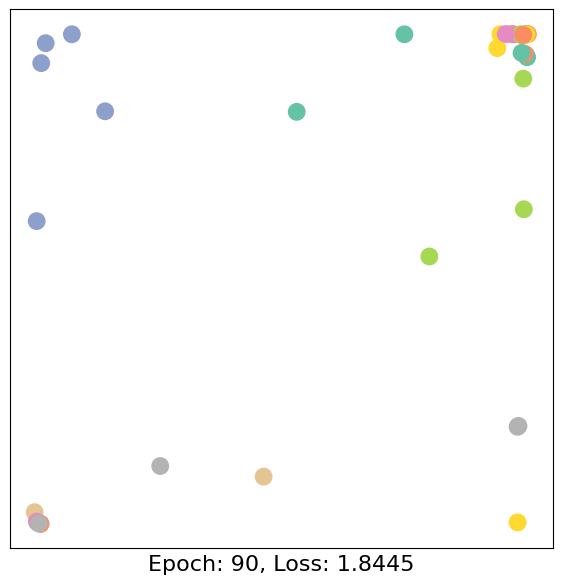

Epoch: 100, Loss: 1.7787


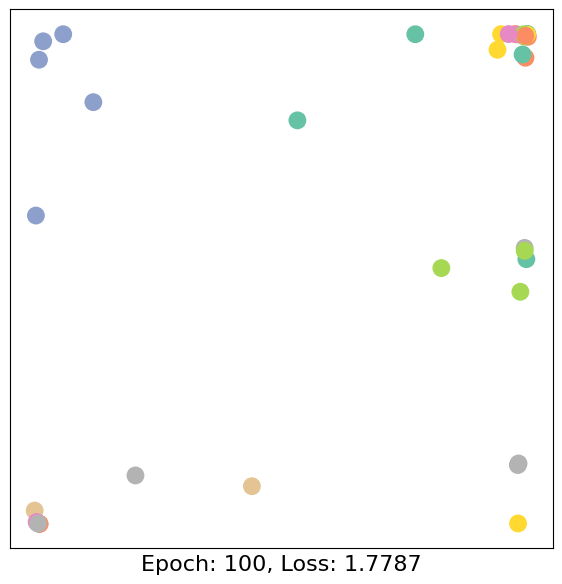

Epoch: 110, Loss: 1.7227


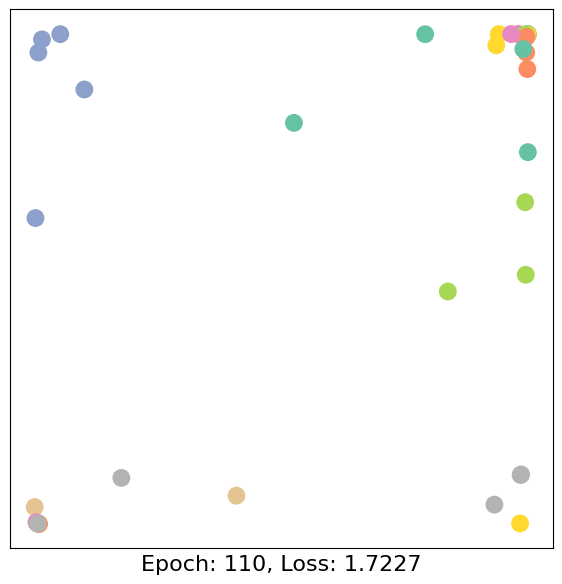

Epoch: 120, Loss: 1.6794


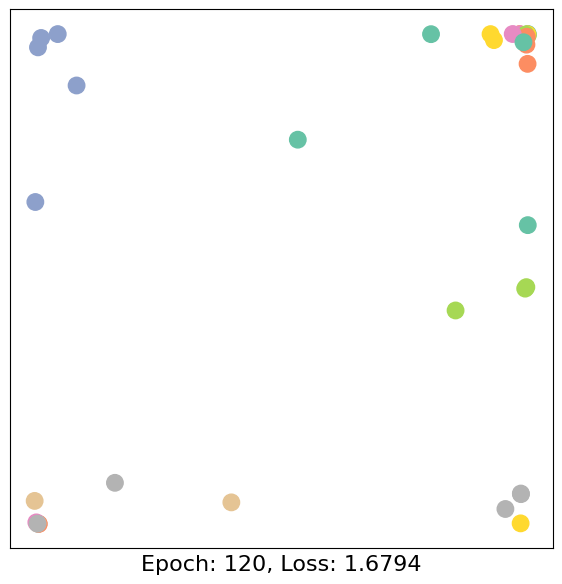

Epoch: 130, Loss: 1.6427


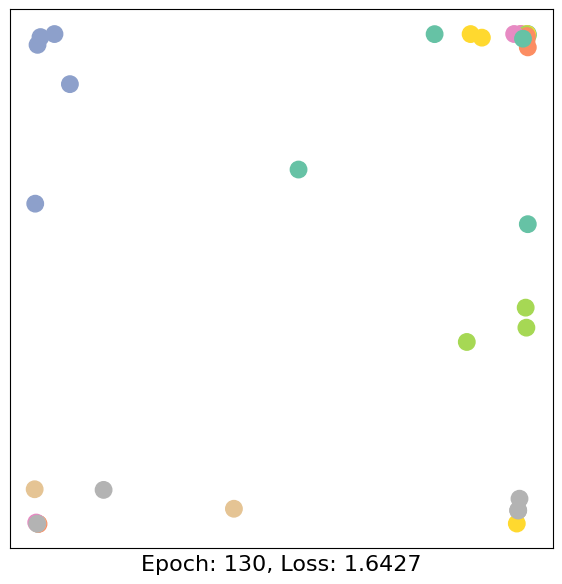

Epoch: 140, Loss: 1.6124


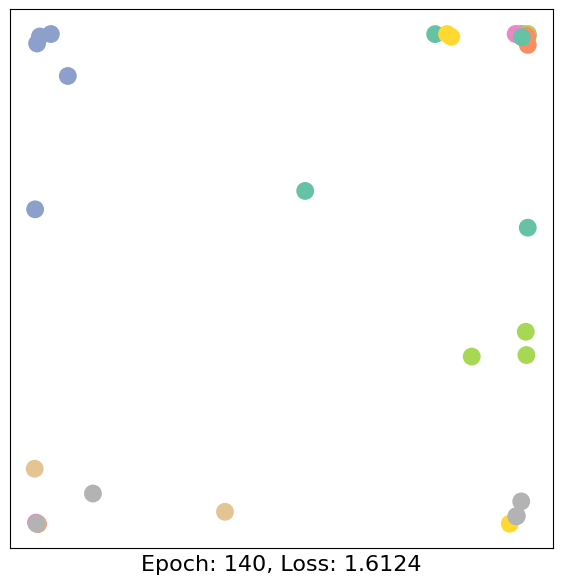

Epoch: 150, Loss: 1.5862


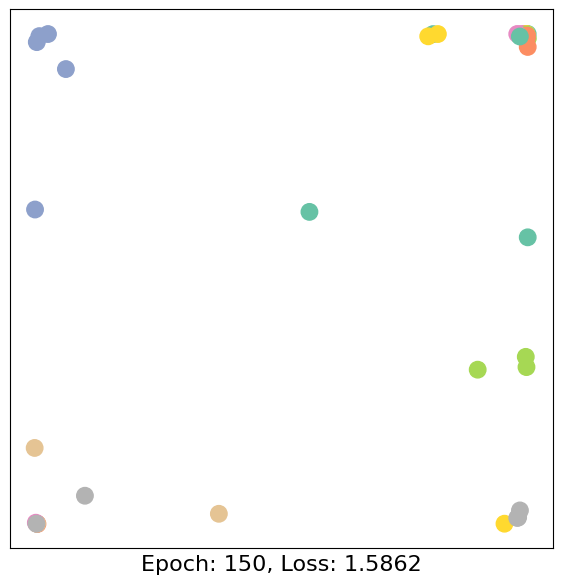

Epoch: 160, Loss: 1.5593


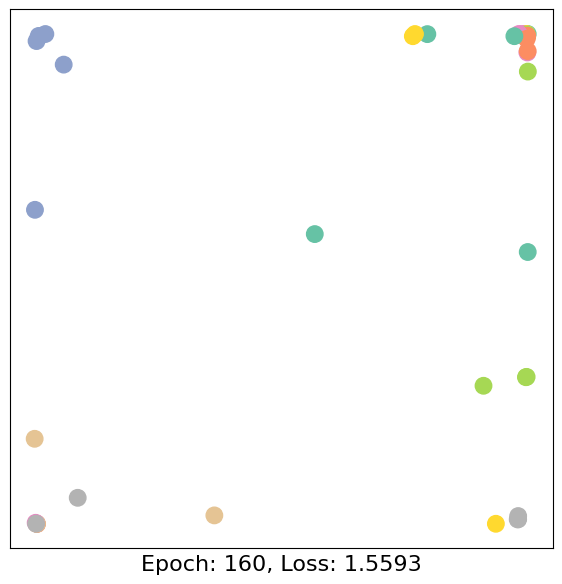

Epoch: 170, Loss: 1.5154


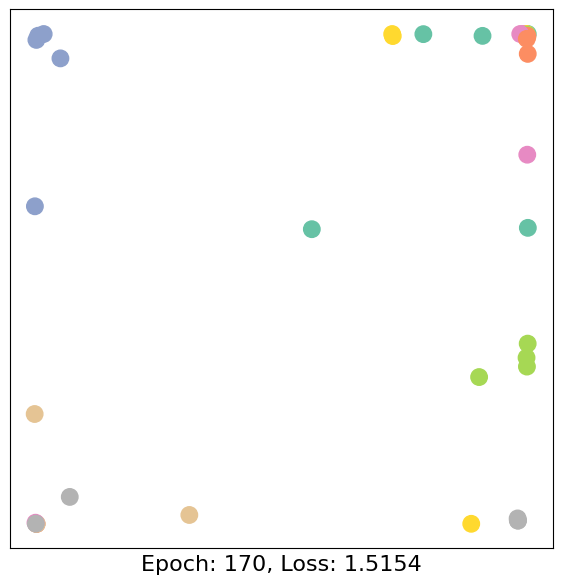

Epoch: 180, Loss: 1.4854


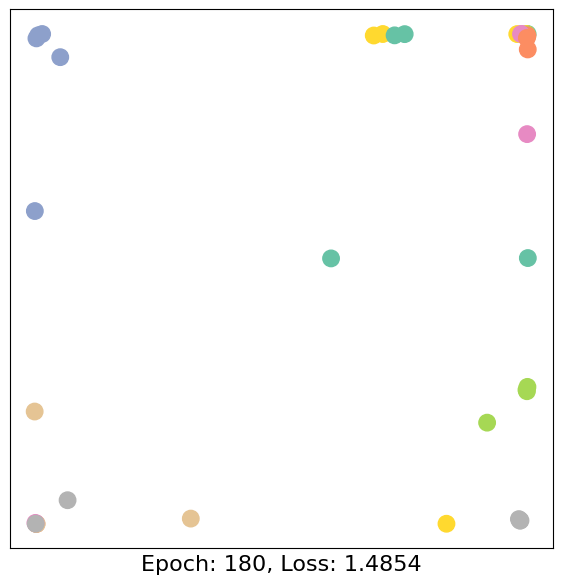

Epoch: 190, Loss: 1.4551


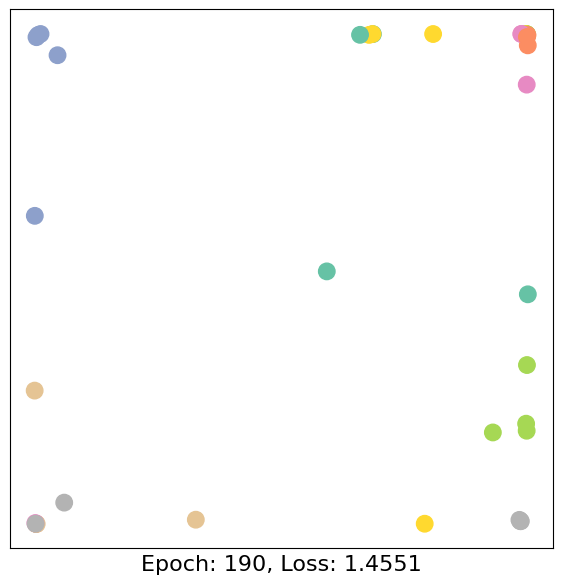

Epoch: 200, Loss: 1.4280


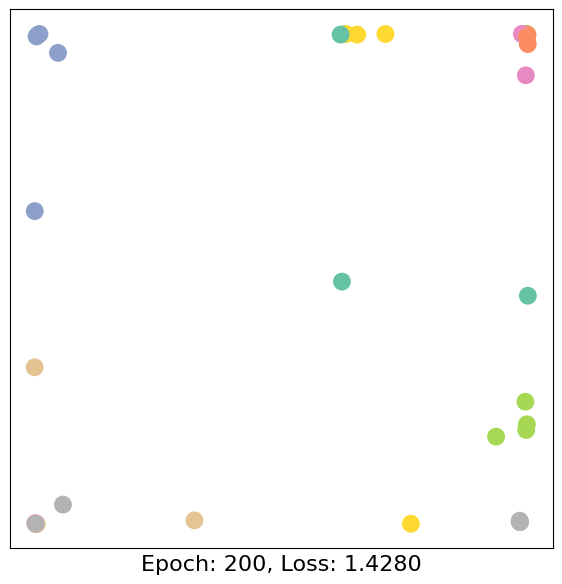

Epoch: 210, Loss: 1.4024


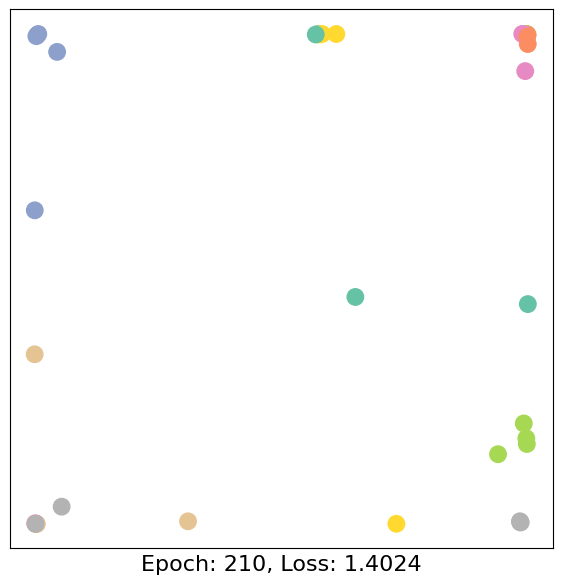

Epoch: 220, Loss: 1.3790


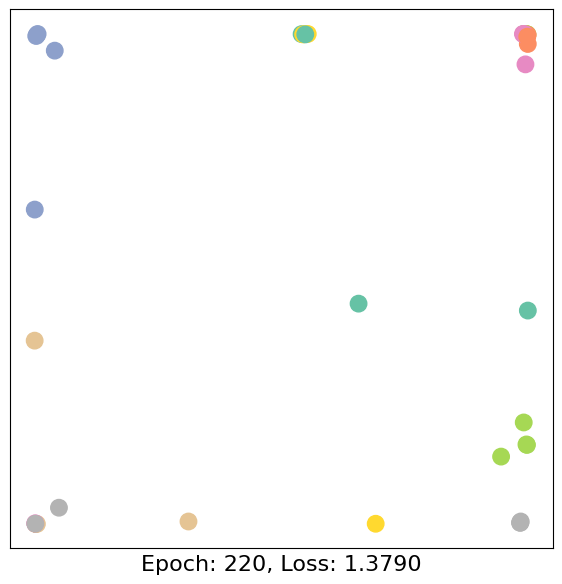

Epoch: 230, Loss: 1.3577


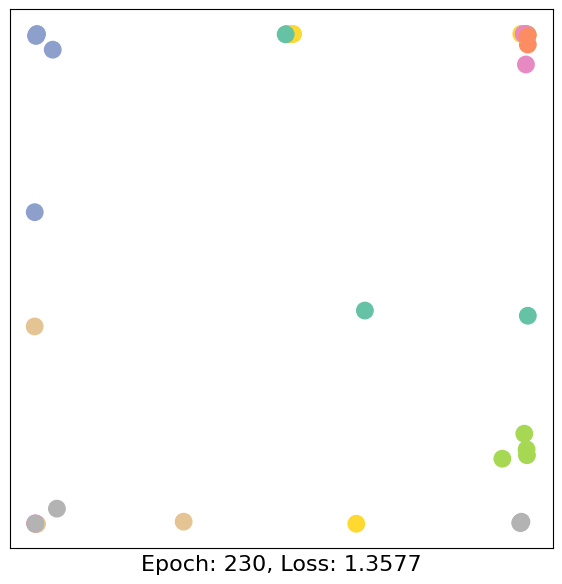

Epoch: 240, Loss: 1.3366


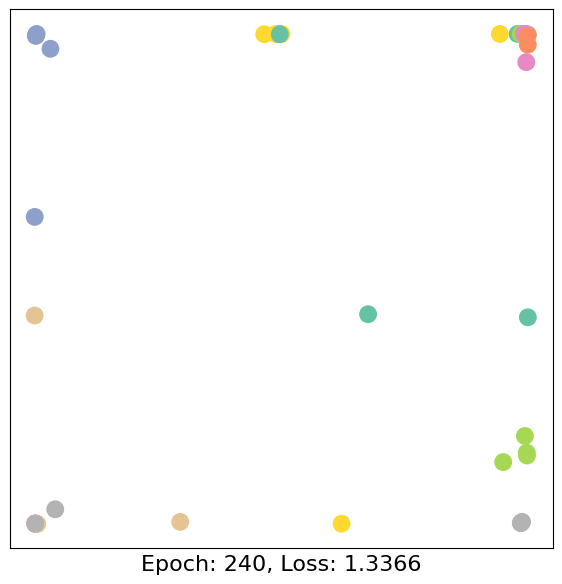

Epoch: 250, Loss: 1.3063


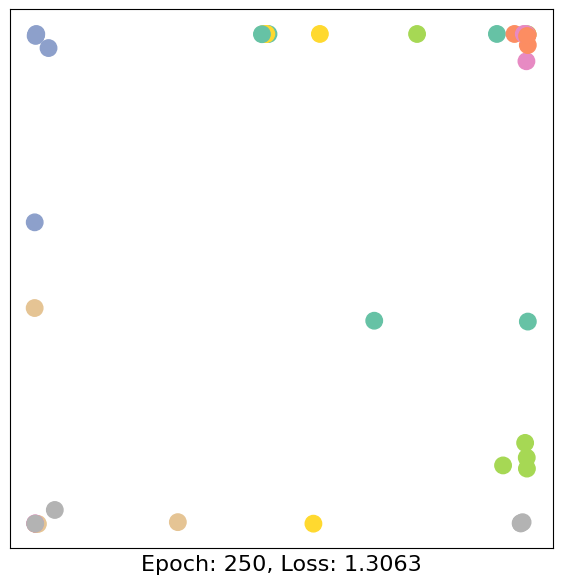

Epoch: 260, Loss: 1.2713


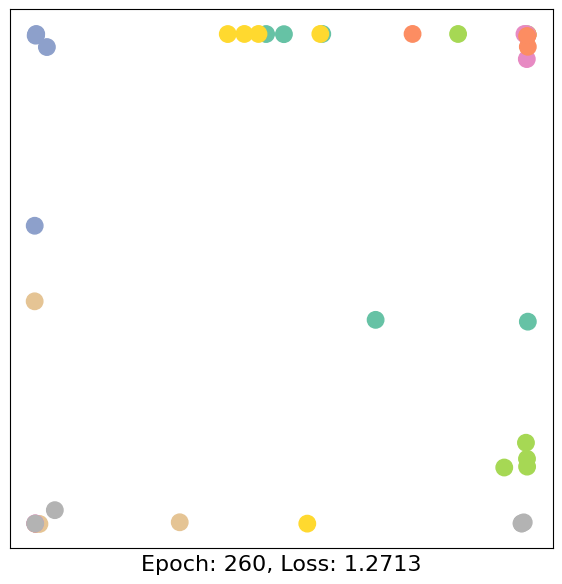

Epoch: 270, Loss: 1.2465


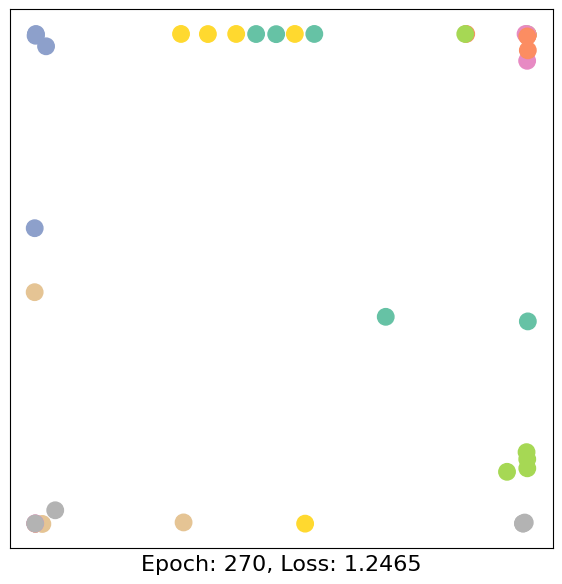

Epoch: 280, Loss: 1.2252


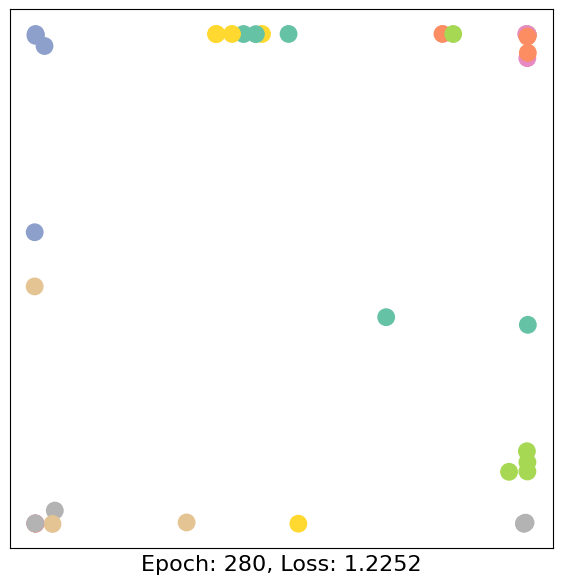

Epoch: 290, Loss: 1.2032


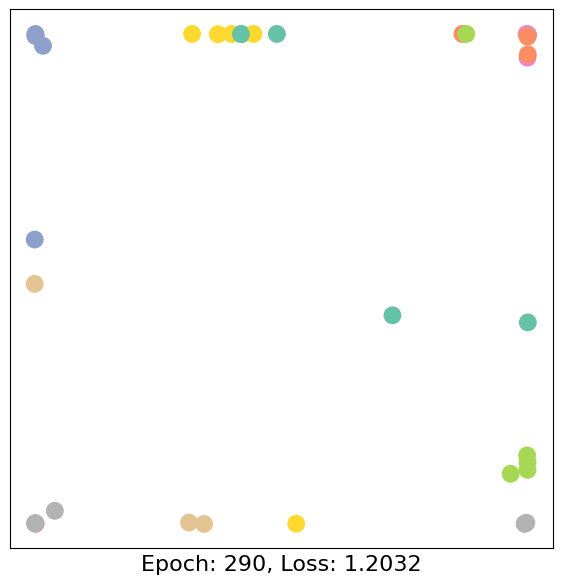

Epoch: 300, Loss: 1.1863


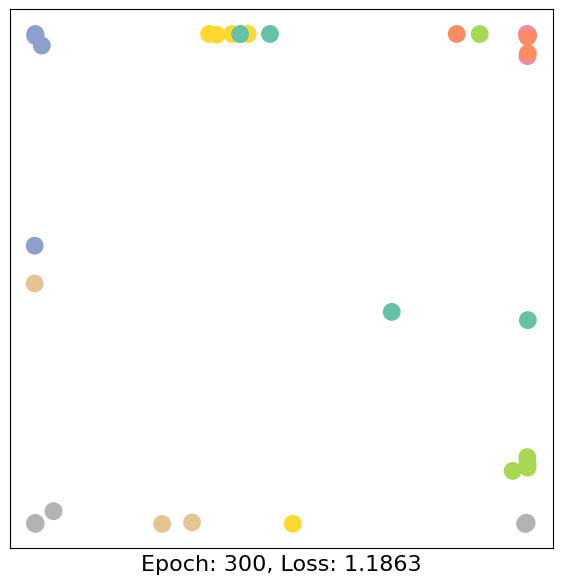

Epoch: 310, Loss: 1.1703


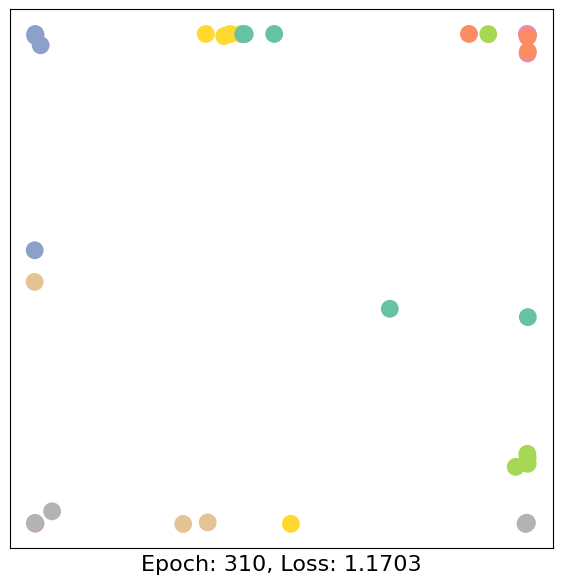

Epoch: 320, Loss: 1.1558


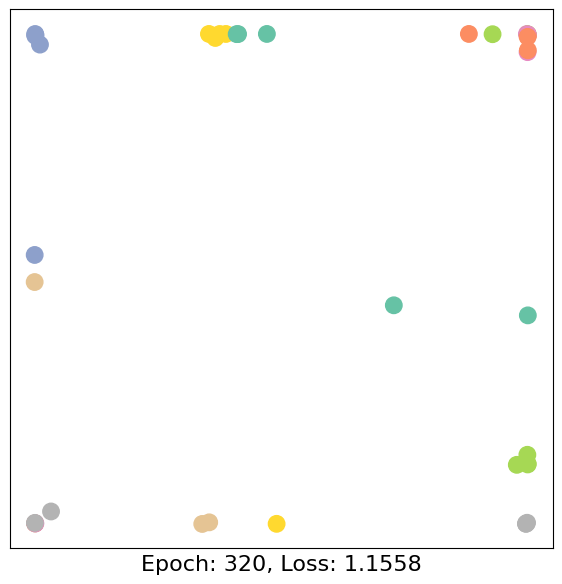

Epoch: 330, Loss: 1.1416


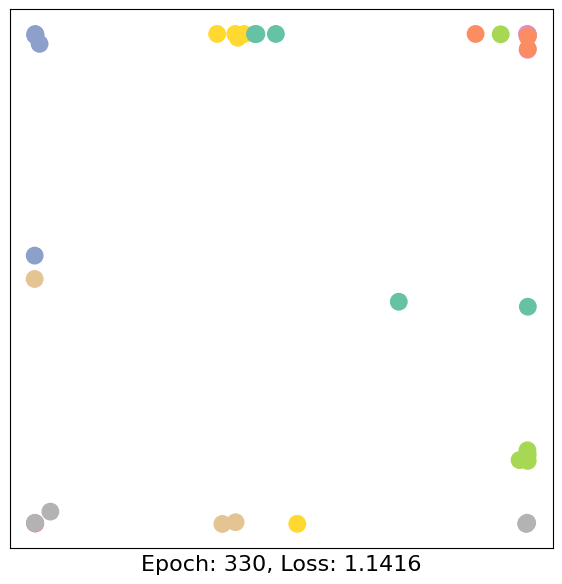

Epoch: 340, Loss: 1.1286


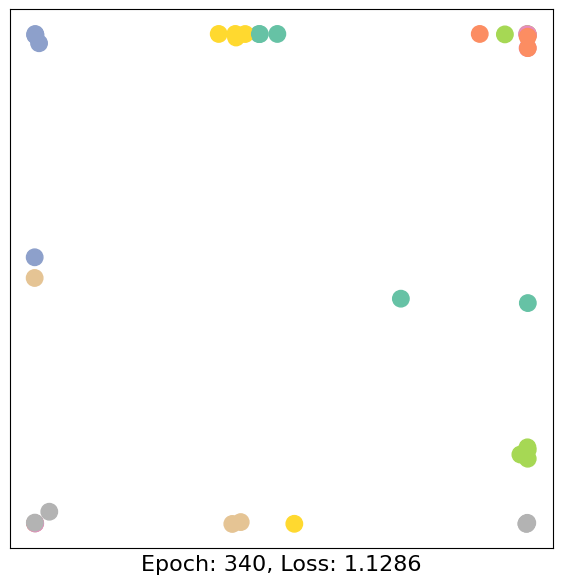

Epoch: 350, Loss: 1.1165


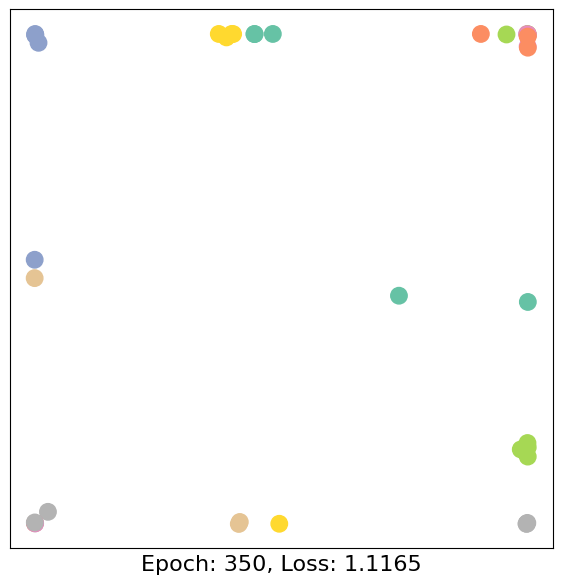

Epoch: 360, Loss: 1.1051


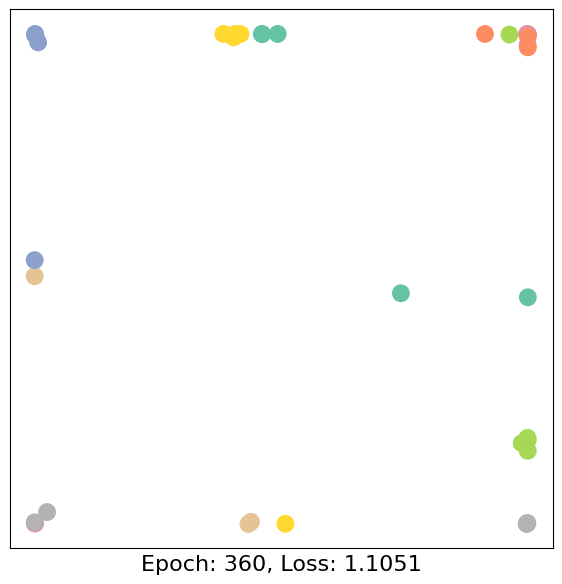

Epoch: 370, Loss: 1.0944


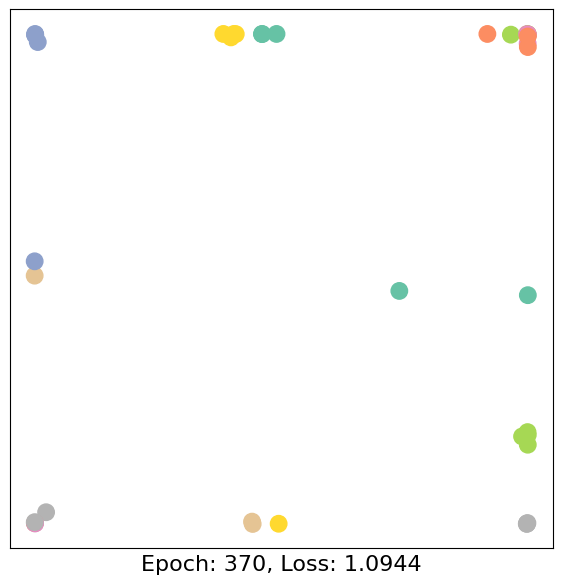

Epoch: 380, Loss: 1.0840


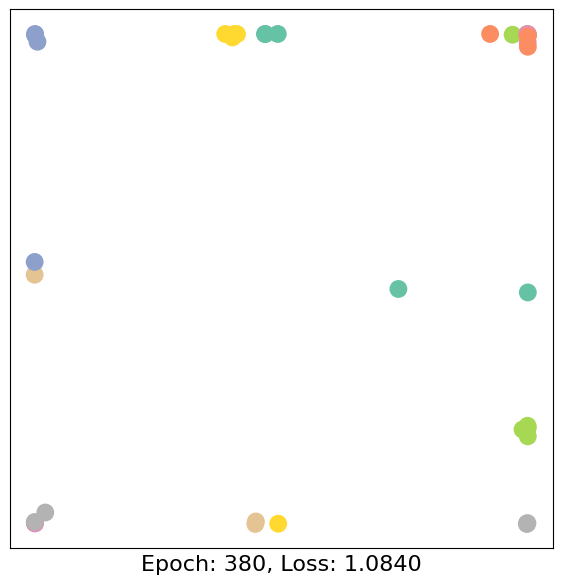

Epoch: 390, Loss: 1.0740


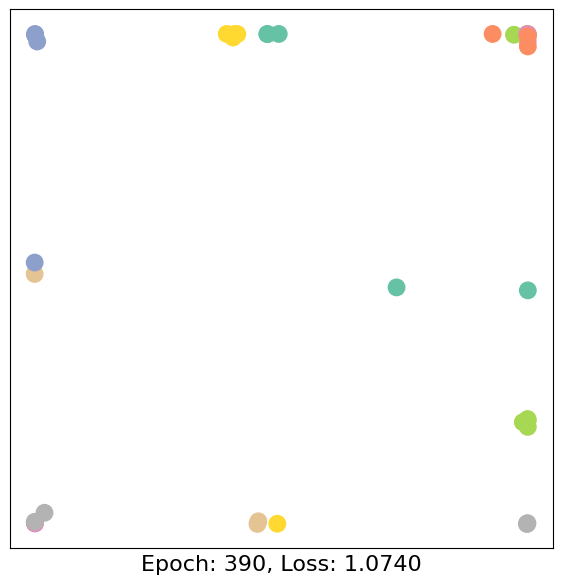

Epoch: 400, Loss: 1.0646


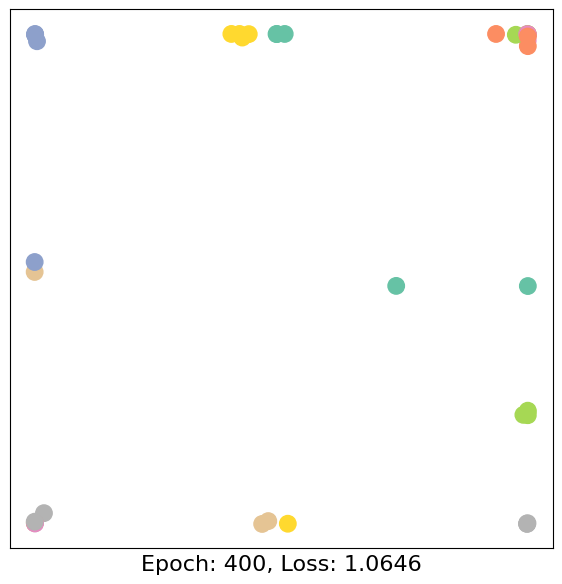

In [21]:
# Training loop
# Training loop
for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# Remove Outlier Clusters

In this example, Cluster 1 including "Ukraine" and Cluster 9 including "Covid-19" and "Entertainment Industry" are removed.

These 2 nodes are not important details in the overall knowledge graph.

Cluster 1 seems important, but is mentioned in other nodes such as "Russia-Ukraine Conflict".

Cluster 9 has nodes rarely mentioned in the text.

In [22]:
# Group and print node values by clusters
clusters = {}
for idx, cluster in enumerate(pred.tolist()):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(idx)

for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 14:
  Node 2023: [ 0.02670481 -0.9990927 ]
  Node Cop28 Summit: [-0.05259829 -0.9882903 ]
  Node Personalized Medicine: [-0.07741878 -0.99997705]
Cluster 16:
  Node Russia-Ukraine Conflict: [-0.96224284 -0.9559241 ]
  Node Amazon: [-0.9989828  -0.99750036]
  Node James Webb Space Telescope: [-0.9993767  -0.99601346]
  Node Environmental Activism: [-0.9985079  -0.99772024]
  Node Great Resignation: [-0.99972093 -0.9907841 ]
Cluster 5:
  Node Russia: [-0.99041814  0.9702444 ]
  Node Middle East: [-0.9984225  0.9999029]
  Node Syria: [-0.9981519  0.9962079]
  Node Climate Change: [-0.99781376  0.99750835]
Cluster 1:
  Node Ukraine: [ 0.46613985 -0.02835393]
Cluster 4:
  Node Nato: [0.9994655 0.9734035]
  Node Iran: [0.9999408  0.99579364]
  Node Burkina Faso: [0.8710722  0.99997956]
  Node Artificial Intelligence: [0.9999801  0.95023483]
  Node Ibm: [0.95128304 0.99662673]
  Node Ai-Generated Music, Art, And Literature: [0.9973206  0.99994206]
  Node Social Justice Movements: [0.9

In [23]:
# Remove clusters with less than 2 nodes
clusters = {cluster: nodes for cluster, nodes in clusters.items() if len(nodes) <= 2}

# Print the remaining clusters and nodes
for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        print(f'  Node {node_id}')

Cluster 1:
  Node Ukraine
Cluster 6:
  Node Covid-19
  Node Entertainment Industry


In [24]:
#Function for removing node by id
def remove_node_by_id(doc, node_id):
    # Remove the node
    doc.nodes = [node for node in doc.nodes if node.id != node_id]
    # Remove any relationships involving the node
    doc.relationships = [rel for rel in doc.relationships if rel.source.id != node_id and rel.target.id != node_id]

clusters_removed = {cluster: nodes for cluster, nodes in clusters.items() if len(nodes) <= 2}
nodes_removed = []
# Print the remaining clusters and nodes
for cluster, nodes in clusters.items():
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        nodes_removed.append(node_id)

for items in nodes_removed:
    for doc in graph_documents:
        remove_node_by_id(doc, items)

In [25]:
for doc in graph_documents:
    # Print the remaining nodes and relationships
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")

    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source.id}, Target: {relationship.target.id}, Type: {relationship.type}")

Nodes:
ID: 2023, Type: Year
ID: Russia-Ukraine Conflict, Type: Event
ID: Russia, Type: Country
ID: Nato, Type: Organization
ID: Eastern Europe, Type: Region
ID: Middle East, Type: Region
ID: Syria, Type: Country
ID: Yemen, Type: Country
ID: Iran, Type: Country
ID: Africa, Type: Continent
ID: Sudan, Type: Country
ID: Burkina Faso, Type: Country
ID: Climate Change, Type: Issue
ID: Cop28 Summit, Type: Event
ID: Dubai, Type: City
ID: Artificial Intelligence, Type: Technology
ID: Gpt-4, Type: Ai model
ID: Meta, Type: Company
ID: Amazon, Type: Company
ID: Google, Type: Company
ID: Quantum Computing, Type: Technology
ID: Ibm, Type: Company
ID: Nasa'S Artemis Program, Type: Program
ID: Artemis Ii, Type: Mission
ID: James Webb Space Telescope, Type: Telescope
ID: Crispr Technology, Type: Technology
ID: Personalized Medicine, Type: Medical approach
ID: Ai-Generated Music, Art, And Literature, Type: Art
ID: Social Justice Movements, Type: Movement
ID: Racial Equality, Type: Issue
ID: Gender Equal